In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
def display(img):
    %config InlineBackend.figure_format = 'retina'
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def draw_line(rho, theta, img):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)    

def draw_cline(y1, x1, y2, x2, img):
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)  
    

TypeError: row_params() missing 1 required positional argument: 'rot_angle'

<Figure size 1440x720 with 0 Axes>

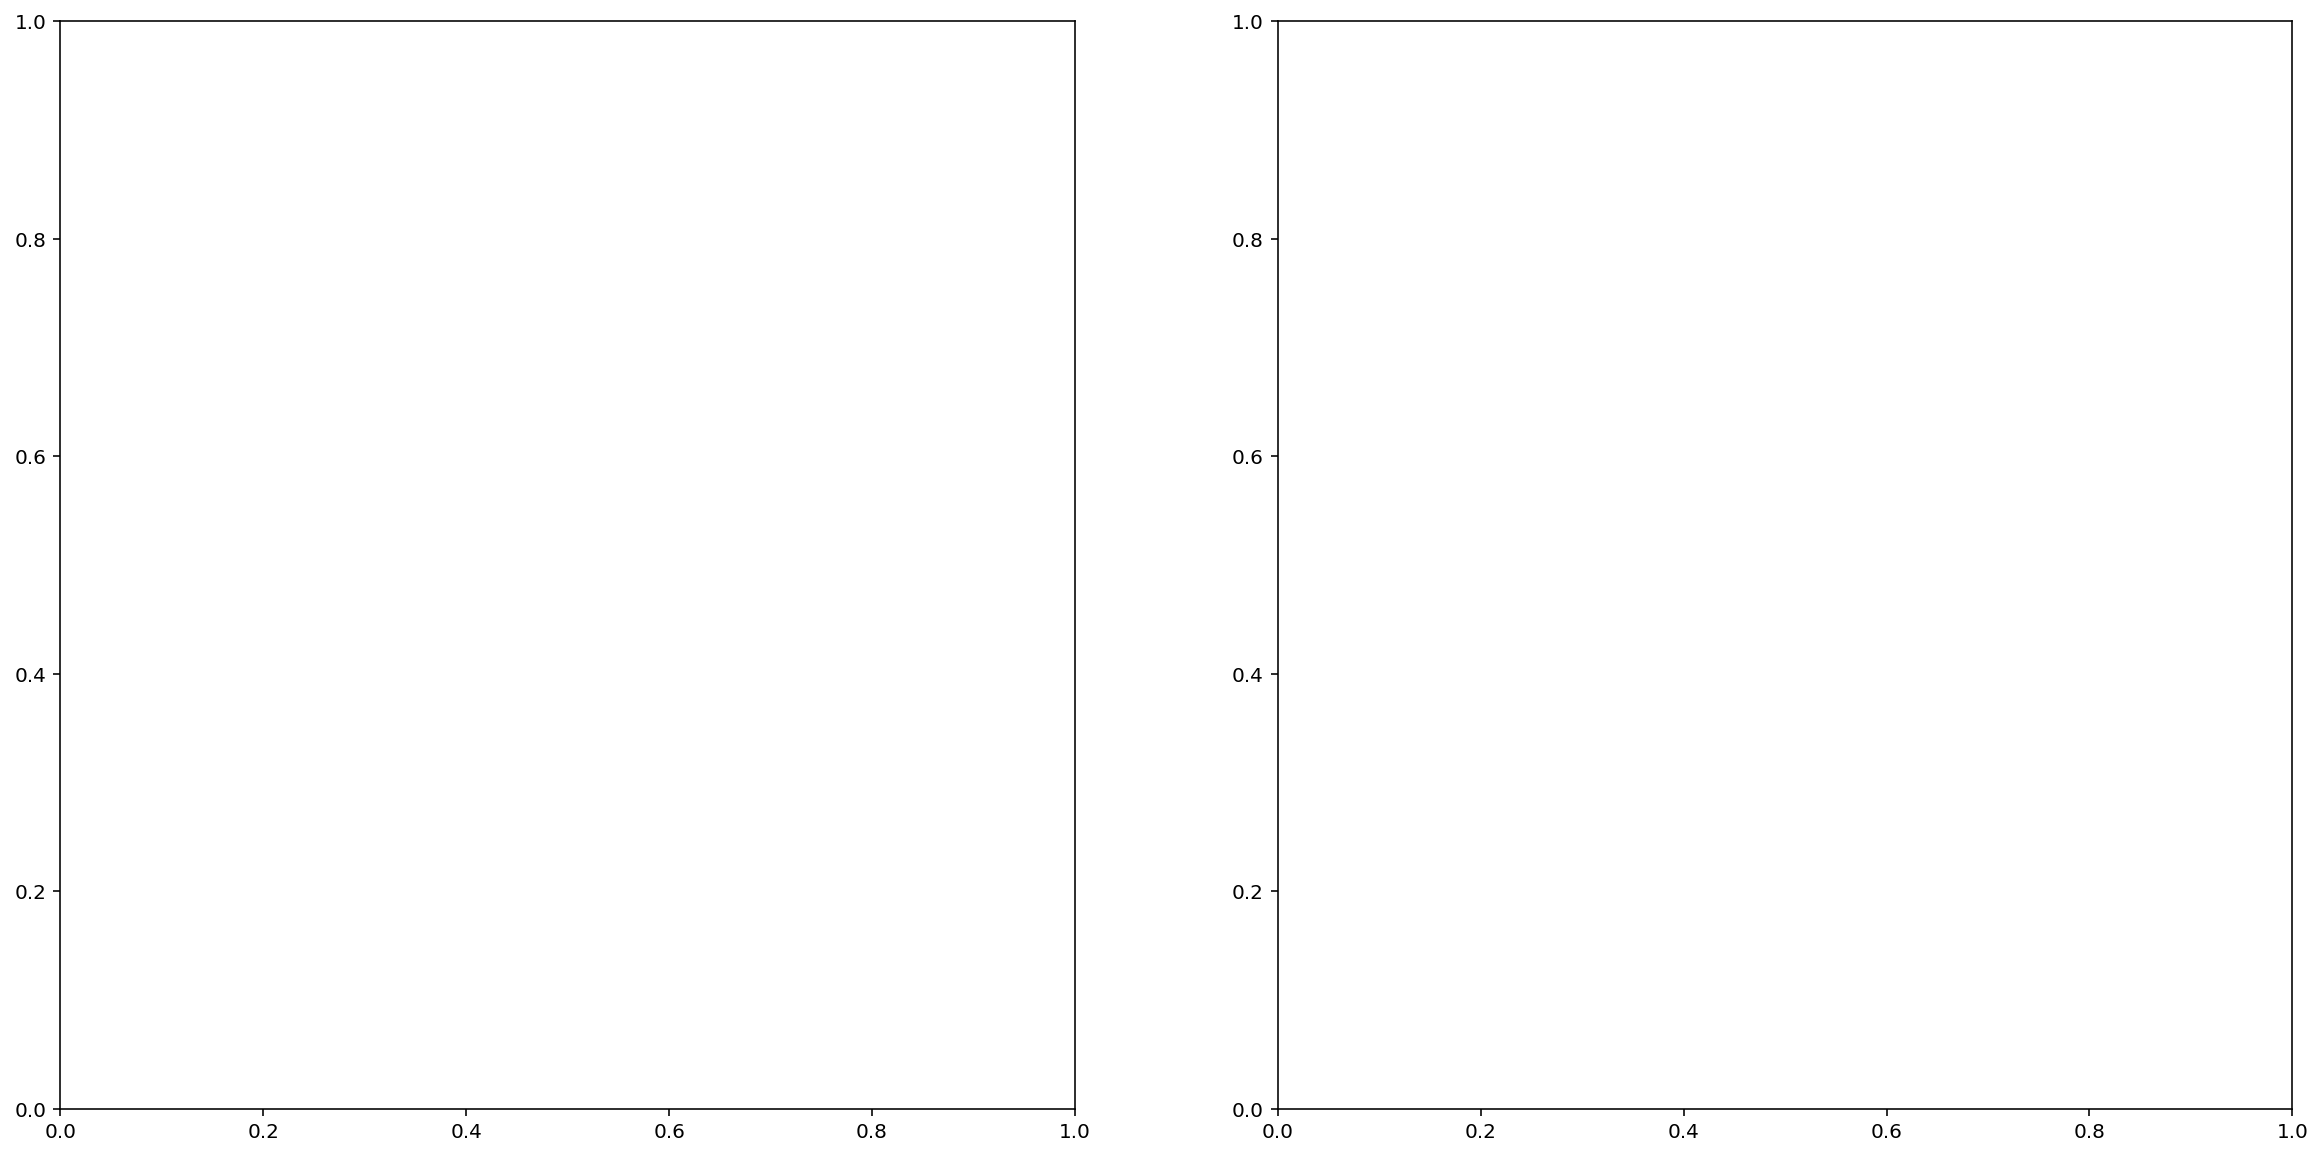

In [112]:
img = cv2.imread('./images/IMG_20200302_141417.jpg')
img = imutils.resize(img, height=500)
h, w, _ = img.shape

def row_params(rot_image, image, rot_angle):
    
    hp, wp = rot_image.shape
    frame = np.zeros(image.shape[:2])
    frame[:, 0] = 255
    frame[:, -1] = 255
    frame[0, :] = 255
    frame[-1, :] = 255
    rot_frame = imutils.rotate_bound(frame, rot_angle)
    
    rfm_idxs = np.nonzero(rot_frame)
    
    prev_y = -1
    prev_x = -1
    split = 0
    merge = hp - 1
    rfm_bd = np.zeros((hp, 2))
    for y, x in zip(*rfm_idxs):
        if y == prev_y and x - prev_x > 1:
            rfm_bd[y, 0] = prev_x
            rfm_bd[y, 1] = x
            if y > 0 and rfm_bd[y-1, 0] == 0:
                if split != 0:
                    if merge == hp-1: merge = y-1
                else: split = y
        prev_y = y
        prev_x = x
        
    rfm_bd[:split, :] = int((rfm_bd[split, 0]+rfm_bd[split, 1])/2)
    rfm_bd[merge:, :] = int((rfm_bd[merge-1, 0]+rfm_bd[merge-1, 1])/2)
    
    #for y, bd in enumerate(rfm_bd):
    #    cv2.circle(rot_image, (int(bd[0]), y), 1, (0, 255, 0), 4)
    #    cv2.circle(rot_image, (int(bd[1]),y), 1, (0, 255, 0), 4)
    #plt.imshow(rot_image)
    #plt.show()
    
    row_min = np.ones(hp) * 255
    row_max = np.zeros(hp)
    for y in range(hp):
        valid_row = rot_image[y, int(rfm_bd[y, 0]):int(rfm_bd[y, 1])]
        #print(rfm_bd[y, 0], rfm_bd[y, 1])
        if len(valid_row): 
            row_min[y] = valid_row.min(axis=0)
            row_max[y] = valid_row.max(axis=0)
        
    return row_min, row_max
        
        
#    display(rot_image)
    
#row_params(img, 30)   
plt.figure()
f, ax = plt.subplots(1, 2)
ax[0].imshow(np.transpose(row_params(img, 30)))
ax[1].imshow(imutils.rotate_bound(cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2], 30))
plt.show()

#cv2.circle(image, (x, y), r, (0, 255, 0), 4)

60.0 2.6179938316345215 -77.0 2.583087205886841
-60.0 2.56563401222229 60.0 2.6179938316345215
45.0 2.6354472637176514 -77.0 2.583087205886841
45.0 2.6354472637176514 -60.0 2.56563401222229
-51.0 2.7227137088775635 45.0 2.6354472637176514


<Figure size 1440x720 with 0 Axes>

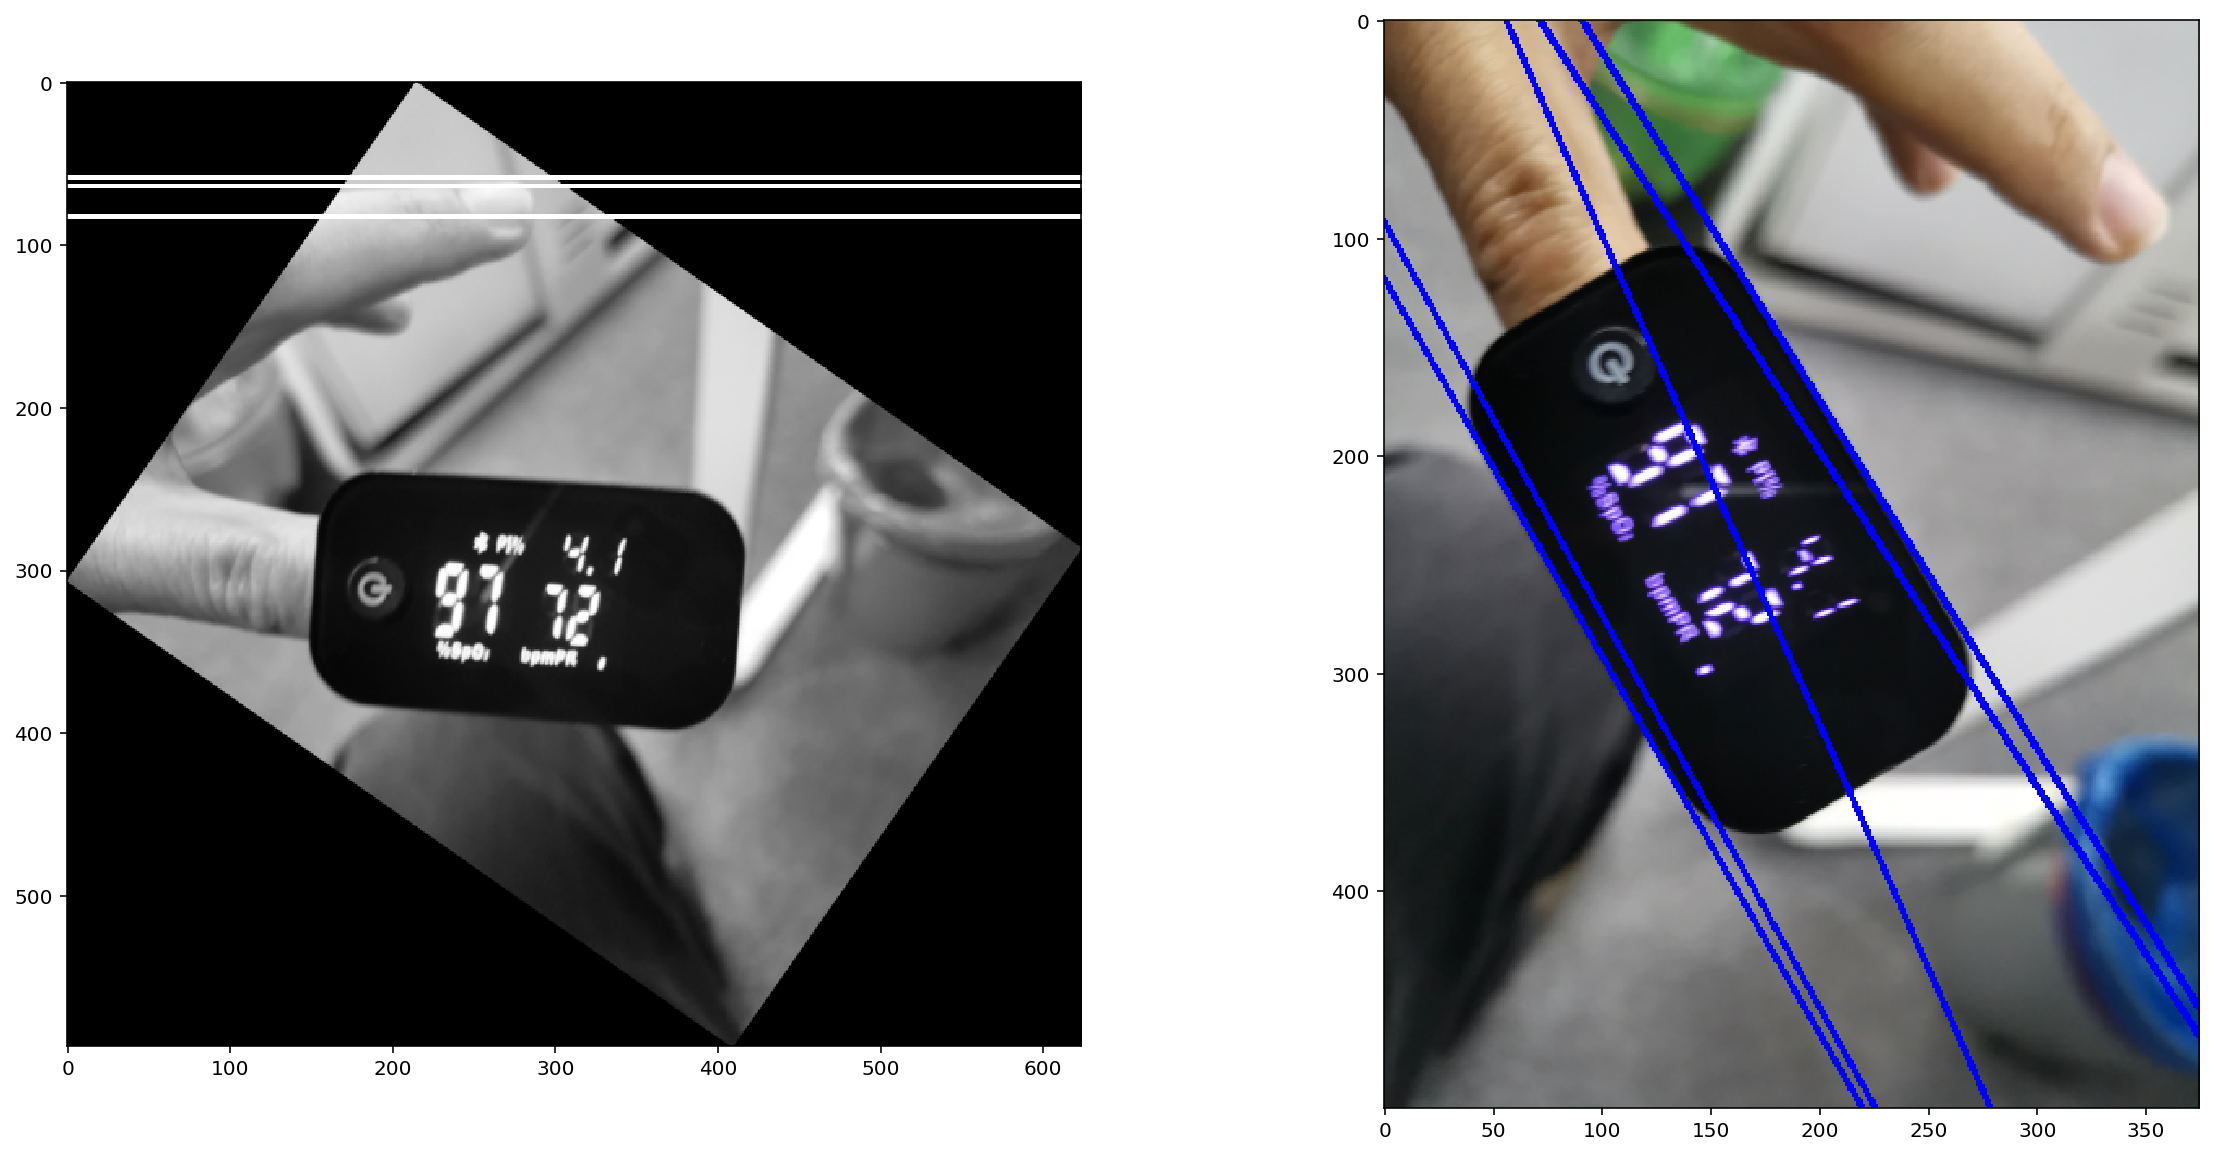

In [124]:
steps = 36
sector_angle = 360//36

def find_screen(org_image):
    org_image = imutils.resize(org_image, height=500)
    imh = org_image.shape[0]
    imw = org_image.shape[1]
    #cropL = 120
    #cropR = 254
    
    #image = org_image[:, cropL:cropR]
    image = org_image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #            cv2.THRESH_BINARY,31, 2)  
    edged = cv2.Canny(blur,  20, 50)
    
    lines = cv2.HoughLines(edged,1,np.pi/180, 1)[0:500]  #assumes descendng order of votes
    lines = np.append(lines, [[[i]] for i in range(len(lines))], axis=2) #mark by order of feature strength
    
    #merge similar lines
    idx = 0 
    while idx < len(lines):
        for jdx in range(idx):
            ri, ti, _ = lines[idx][0]
            rj, tj, _ = lines[jdx][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            if dt < 0.1 and dp < 15:
                lines = np.delete(lines, idx, axis=0)
                idx -= 1
                break
        idx += 1
    
    #find pairs of horizontal parallel lines
    parallel_lines = [[]]*36
    for i in range(len(lines)):
        for j in range(i):
            ri, ti, si = lines[i][0]
            rj, tj, sj = lines[j][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            #parallel, some distance apart
            if dt<0.1 and 75<dp<200:
                sector = ((ti/np.pi*180) % 360) // sector_angle
                parallel_lines[int(sector)].append([ri, ti, si, rj, tj, sj])
                #draw_line(ri, ti, org_image)
                #draw_line(rj, tj, org_image)
    
    for s in range(len(parallel_lines)):
        parallel_lines[s].sort(key=lambda p: (p[2]*p[2]+p[5]*p[5]))
        parallel_lines[s] = parallel_lines[s][:5] #adjust
        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:,:,2]
    
    for step in [5]: #range(steps):
        
        rot_angle = int(step * sector_angle + sector_angle/2)
        rot_hsv = imutils.rotate_bound(hsv, -rot_angle)
        row_min, row_max = row_params(rot_hsv, hsv, rot_angle)
        
        for ri, ti, si, rj, tj, sj in parallel_lines[step]:
            print(ri, ti, rj, tj)
            if 0<=rot_angle<90:
                hi = ri / np.cos(rot_angle/180*np.pi - ti)
                hj = rj / np.cos(rot_angle/180*np.pi - tj)
            elif 90<=rot_angle<180:
                hi = imh * np.cos(rot_angle/180*np.pi - np.pi/2) - ri / np.cos(rot_angle/180*np.pi - ti)
                hj = imh * np.cos(rot_angle/180*np.pi - np.pi/2) - rj / np.cos(rot_angle/180*np.pi - tj)
            
            #print(hi, hj)
            
            draw_line(ri, ti, image)
            draw_line(rj, tj, image)
            
            draw_line(hi, np.pi/2, rot_hsv)
            draw_line(hj, np.pi/2, rot_hsv)
        
        return image
            

        """
        hi = int(ri*np.sin(ti))
        hj = int(rj*np.sin(tj))
        region = row_color[min(hi,hj):max(hi,hj), :]
        l = len(region)
        margin = 0.2
        top_value = np.mean(region[:int(margin*l), :])
        btm_value = np.mean(region[-int(margin*l):, :])
        mid_value = np.mean(region[int(margin*l):-int(margin*l), :])
        score = mid_value - 2*(top_value+btm_value)/2   #weighted
        if score > best_score:
            best_score = score
            long_edges = [ri, ti, rj, tj]
        """   
    #return org_image
                         
            

img = cv2.imread('./images/IMG_20200302_141318.jpg')
#find_screen(img)
plt.imshow(find_screen(img))
plt.show()
                               
plt.figure()
##f, ax = plt.subplots(1, 2)
#l = find_screen(img)
#ax[0].imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))
#ax[1].imshow(cv2.cvtColor(l, cv2.COLOR_BGR2RGB))
#plt.show()


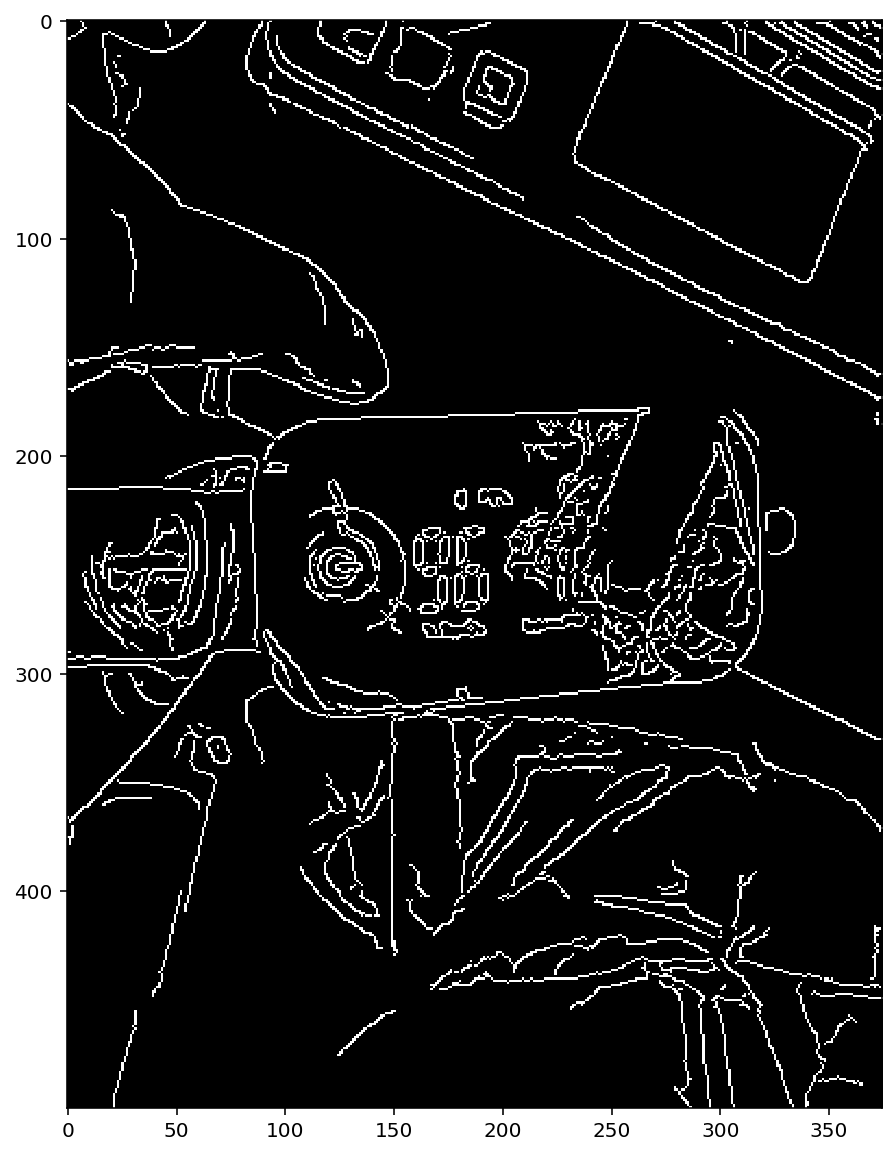

In [21]:
img = cv2.imread('./images/IMG_2826.JPG')
img = imutils.resize(img, height=500)
h, w, _ = img.shape

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
edged = cv2.Canny(blur, 20, 50)

    
display(edged)